This file is to convert Ben's sgm4fMRI matlab code to python

also including testing part.

Checked with Ben's matlab code ,refer to obsidian. (on Nov 30, 2023)

In [1]:
import sys
sys.path.append("../../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT
from utils.misc import load_pkl, save_pkl, get_ball_cor
from utils.colors import qual_cmap
from utils.measures import reg_R_fn
from sgm_fMRI.utils import minmax_fn, obt_psd_at_freqs
from sgm_fMRI.sgm import sgm_fMRI

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

In [5]:
import logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

if not logger.hasHandlers():
    ch = logging.StreamHandler() # for console. 
    ch.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    
    # add formatter to ch
    ch.setFormatter(formatter)
    
    logger.addHandler(ch)

In [6]:
logger.handlers[0].setLevel(logging.WARNING)

# Fns and params

## Some fns

In [7]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
def _get_fc(ts, is_fisher=True):
    """Get FC from ts, including 
        1. Pearsons'r 
        2. fisher transform
        3. abs value
    """
    fc = np.corrcoef(ts)
    fc = fc - np.diag(np.diag(fc))
    return fc

    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [8]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");

# some parameters

num_rois = 246 # the BNA has 246 regions
num_sps = 321
SC_mat = loadmat(DATA_ROOT/"SC_HC_BN_template_nature_order.mat")["SC_template"];
#np.savetxt(MIDRES_ROOT/"sc.txt", SC_mat)

In [48]:
sub_ix = 3
ts = _load_data(sub_ix)[:num_rois]
data = _preprocess_ts(ts).T; # num of time pts x num of ROIs
np.savetxt(MIDRES_ROOT/"data.txt", data)

In [55]:
fit_instance = sgm_fMRI(SC_mat);
fit_instance.add_data(data, model_focus="both", perc_thresh=False, fitmean=False, eig_weights=False)
fit_instance.fit()

2023-11-30 15:26:32,727 - sgm_fMRI.sgm - DEBUG - {'TR': 2, 'fband': [0.008, 0.08], 'costtype': 'corr', 'perc_thresh': False, 'eig_weights': False, 'deconvHRF': False, 'is_ann': False, 'model_focus': 'both', 'fitmean': False}
2023-11-30 15:26:32,727 - sgm_fMRI.sgm - DEBUG - {'TR': 2, 'fband': [0.008, 0.08], 'costtype': 'corr', 'perc_thresh': False, 'eig_weights': False, 'deconvHRF': False, 'is_ann': False, 'model_focus': 'both', 'fitmean': False}
2023-11-30 15:26:32,756 - sgm_fMRI.sgm - DEBUG - {'theta0': [0.5, 1], 'maxiter': 1000, 'bds': [[0.1, 10], [0.1, 5]]}
2023-11-30 15:26:32,756 - sgm_fMRI.sgm - DEBUG - {'theta0': [0.5, 1], 'maxiter': 1000, 'bds': [[0.1, 10], [0.1, 5]]}


In [56]:
fit_instance.fit_res, fit_instance.emp_fc.sum()

(      fun: 1.3378362744653831
  hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
       jac: array([-0.00000000e+00,  4.44089213e-08])
   message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
      nfev: 42
       nit: 7
      njev: 14
    status: 0
   success: True
         x: array([10.        ,  2.51802195]),
 9067.59621821769)

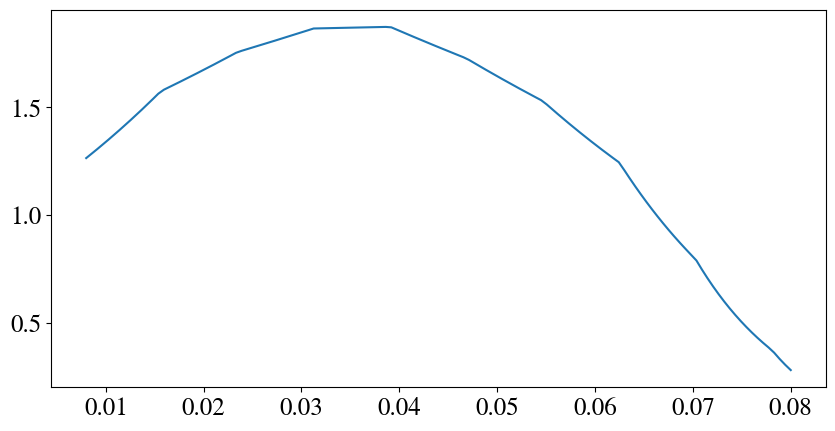

In [57]:
plt.plot(fit_instance.omegavec/np.pi/2, fit_instance.emp_psd[:, 0])

In [58]:
fit_instance.forward_FX([0.5, 1])

array([[0.22351842, 0.0447422 , 0.20173269, ..., 0.12593917, 0.31976714,
        0.57984049],
       [0.22373308, 0.04479975, 0.20192919, ..., 0.12606059, 0.32008605,
        0.580392  ],
       [0.22396269, 0.04486134, 0.20213938, ..., 0.12619048, 0.32042723,
        0.58098197],
       ...,
       [0.42684251, 0.10624804, 0.38668662, ..., 0.23959391, 0.64451122,
        1.14093766],
       [0.43077247, 0.10744132, 0.39016972, ..., 0.24165714, 0.65134299,
        1.15309833],
       [0.43475789, 0.10864432, 0.39369473, ..., 0.2437347 , 0.65828581,
        1.16548856]])

In [59]:
fit_instance.forward_FC([0.5, 1])

array([[ 0.99982318,  0.07236566,  0.07593912, ..., -0.00151899,
         0.00696423, -0.00157782],
       [ 0.07236566,  0.99982245,  0.01759664, ...,  0.00202336,
        -0.00395009,  0.00210689],
       [ 0.07593912,  0.01759664,  0.99982305, ..., -0.00453408,
         0.00873459, -0.00289573],
       ...,
       [-0.00151899,  0.00202336, -0.00453408, ...,  0.99982148,
        -0.00243152,  0.01638759],
       [ 0.00696423, -0.00395009,  0.00873459, ..., -0.00243152,
         0.99982179, -0.00113304],
       [-0.00157782,  0.00210689, -0.00289573, ...,  0.01638759,
        -0.00113304,  0.99982189]])